# Cart Pole

In [1]:
import torch
from torch import nn, optim, tensor
# from torchsummary import summary

# import gym

from collections import deque, namedtuple

import matplotlib
import matplotlib.pyplot as plt

import random

from math import exp

import numpy as np
from itertools import compress
import time
import json
from src.Runner2048 import Game

## Setup

In [2]:
# So we can run off of the GPU for our tensors
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# Live plots
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# plt.rcParams['figure.figsize'] = [10, 12]
plt.rcParams['figure.figsize'] = [10, 8]

print(device)

OHE = True
CNN = True
XTRA_IN = False

cuda


## Environment

In [3]:
env = Game(seed=1, board_size=4, reward_type='hs')
action_dict = {0:'U', 1:'R', 2:'D', 3:'L'}

## Parameters

In [4]:
# Parameters
nS = 16
nA = 4

# Hyperparameters
# BATCH_SIZE = 2**7
# BATCH_SIZE = 2**5
BATCH_SIZE = 2**6

# LAYER1_SIZE = 128
# LAYER2_SIZE = 128
# LAYER1_SIZE = 64
# LAYER2_SIZE = 128

# EPISODES_TRAINING = 1000
# EPISODES_TRAINING = 2000
EPISODES_TRAINING = 25000

ALPHA = 5e-5
# ALPHA = 1e-2
GAMMA = 0.99
# TAU = 0.005
TAU = 0.01
# TAU = 1.00
# EPSILON_MAX = 1.00
# EPSILON_MIN = 0.05
# EPSILON_DECAY = 350
EPSILON_MAX = 0.00
EPSILON_MIN = 0.07
# EPSILON_DATA = [EPSILON_MAX, EPSILON_MIN, EPSILON_DECAY]

BUFFER_SIZE = 50000
# BUFFER_SIZE = 1000

## Replay Buffer

In [5]:
SARST = namedtuple("SARST", ["S", "A", "R", "S_prime", "T"])

class ReplayBuffer(object):
    def __init__(self, size):
        self.buffer = deque([], size)

    def push(self, *args):
        self.buffer.append(SARST(*args))
        # Rotate the board and add it to the buffer
        if (False):
            # 90 degrees CCW
            S_new = tensor([np.rot90(args[0].cpu().view(4,4)).flatten()]).to(device)
            A_new = (args[1]-1)%4
            if (args[3] == [0]):
                S_prime_new = args[3]
            else:
                S_prime_new = tensor([np.rot90(args[3].cpu().view(4,4)).flatten()]).to(device)
            self.buffer.append(SARST(S_new, A_new, args[2], S_prime_new, args[4]))

            # 180 degrees CCW
            S_new = tensor([np.rot90(S_new.cpu().view(4,4)).flatten()]).to(device)
            A_new = (A_new-1)%4
            if (args[3] == [0]):
                S_prime_new = args[3]
            else:
                S_prime_new = tensor([np.rot90(S_prime_new.cpu().view(4,4)).flatten()]).to(device)
            self.buffer.append(SARST(S_new, A_new, args[2], S_prime_new, args[4]))

            # 270 degrees CCW
            S_new = tensor([np.rot90(S_new.cpu().view(4,4)).flatten()]).to(device)
            A_new = (A_new-1)%4
            if (args[3] == [0]):
                S_prime_new = args[3]
            else:
                S_prime_new = tensor([np.rot90(S_prime_new.cpu().view(4,4)).flatten()]).to(device)
            self.buffer.append(SARST(S_new, A_new, args[2], S_prime_new, args[4]))

            # Flip Virt
            S_new = tensor([np.flip(args[0].cpu().view(4,4).numpy(), axis=0).flatten()]).to(device)
            if (args[1]%2 == 0):
                A_new = (args[1]-2)%4
            else:
                A_new = args[1]
            
            if (args[3] == [0]):
                S_prime_new = args[3]
            else:
                S_prime_new = tensor([np.flip(args[3].cpu().view(4,4).numpy(), axis=0).flatten()]).to(device)
            self.buffer.append(SARST(S_new, A_new, args[2], S_prime_new, args[4]))
            
            # Flip Horz
            S_new = tensor([np.flip(args[0].cpu().view(4,4).numpy(), axis=1).flatten()]).to(device)
            if (args[1]%2 == 1):
                A_new = (args[1]-2)%4
            else:
                A_new = args[1]
            
            if (args[3] == [0]):
                S_prime_new = args[3]
            else:
                S_prime_new = tensor([np.flip(args[3].cpu().view(4,4).numpy(), axis=1).flatten()]).to(device)
            self.buffer.append(SARST(S_new, A_new, args[2], S_prime_new, args[4]))


    def sample(self, sample_size):
        return random.sample(self.buffer, sample_size)
    
    def __len__(self):
        return len(self.buffer)

## One Hot Encode Board

In [6]:
def encode_state(board):
  board_flat = torch.LongTensor(board)
  board_flat = nn.functional.one_hot(board_flat, num_classes=16).float().flatten()
  board_flat = board_flat.reshape(1, 4, 4, 16).permute(0, 3, 1, 2)
  return board_flat

In [7]:
BOARDBUFF = namedtuple("BOARDBUFF", ["S", "D"]) # Board state, Game duration

class BoardBuffer(object):
    def __init__(self, size):
        self.buffer = deque([], size)

    def push(self, *args):
        self.buffer.append(BOARDBUFF(*args))

    def pop_sample(self):
        pop_index = random.randint(0, len(self.buffer)-1)
        return_board = self.buffer[pop_index]
        del self.buffer[pop_index]
        return return_board
    
    def __len__(self):
        return len(self.buffer)
    
BOARDCACHE = namedtuple("BOARDCACHE", ["S", "D"]) # Board state, Game duration

class BoardCache(object):
    def __init__(self, size):
        self.buffer = deque([], size)

    def clear(self):
        self.buffer.clear()

    def push(self, *args):
        self.buffer.append(BOARDCACHE(*args))

    def get_first(self):
        return self.buffer.popleft()
    
    def __len__(self):
        return len(self.buffer)

## DQN

Since the features that we care about only tend to be in the verical or horizontal directions, we would only want to find correlation between those. Looking in the diagonals would cause extra noise. Since we cannot move in diagonals, it would be efficient to look only vertically and horizontally. It would stand to reason that a square kernel could also learn these features, however, it would require more training and the values at the corner of the kernel would be close to, if not, zero. To achieve only looking at the vertical and horizontal moves, we used non-square kernels (shape [1,2] and [2,1]) to achieve this.

In [8]:
class DQN(nn.Module):
    def __init__(self, INPUT_LAYER, LAYER1_SIZE, LAYER2_SIZE, OUTPUT_LAYER):
        super(DQN, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(INPUT_LAYER, LAYER1_SIZE),
            nn.ReLU(),
            nn.Linear(LAYER1_SIZE, LAYER2_SIZE),
            nn.ReLU(),
            nn.Linear(LAYER2_SIZE, OUTPUT_LAYER),
        ).to(device)

    def forward(self, x):
        return self.linear_relu_stack(x)
    
class DQN2(nn.Module):
    def __init__(self, INPUT_LAYER, LAYER1_SIZE, LAYER2_SIZE, OUTPUT_LAYER):
        super(DQN2, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(INPUT_LAYER+2, LAYER1_SIZE),  # +2 for the duration and max tile value
            nn.ReLU(),
            nn.Linear(LAYER1_SIZE, LAYER2_SIZE),
            nn.ReLU(),
            nn.Linear(LAYER2_SIZE, OUTPUT_LAYER),
        ).to(device)

    def forward(self, x):
        return self.linear_relu_stack(x)
    
class DQCNN(nn.Module):
    def __init__(self, KERNEL_SIZE, LAYER1_SIZE, LAYER2_SIZE, OUTPUT_LAYER):
        super(DQCNN, self).__init__()
        self.cnn = nn.Sequential(   #(H + self.padding*2 - self.kernel_size) // self.stride + 1 -> 4 + 2 - 3 // 1 + 1 = 4
            nn.Conv2d(in_channels=1,  out_channels=16, kernel_size=KERNEL_SIZE, stride=1, padding=1),  # 1x4x4  -> 16x4x4
            nn.ReLU(),  # 16x4x4
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=KERNEL_SIZE, stride=1, padding=1),  # 16x4x4 -> 32x4x4
            nn.ReLU(),  # 32x4x4
            nn.Flatten(),   # 32*4*4 = 512
            nn.Linear(512, LAYER1_SIZE),
            nn.ReLU(),
            nn.Linear(LAYER1_SIZE, LAYER2_SIZE),
            nn.ReLU(),
            nn.Linear(LAYER2_SIZE, LAYER2_SIZE),
            nn.ReLU(),
            nn.Linear(LAYER2_SIZE, OUTPUT_LAYER),
            )
        
    def forward(self, x):
        return self.cnn(x)
    
class DQCNN16(nn.Module):
    def __init__(self, LAYER_SIZE, OUTPUT_LAYER):
        super(DQCNN16, self).__init__()
        self.cnn = nn.Sequential(   #(H + self.padding*2 - self.kernel_size) // self.stride + 1 -> 4 + 2 - 3 // 1 + 1 = 4
            # nn.Conv2d(in_channels=16,  out_channels=512, kernel_size=3, stride=1, padding='same'),  # 1x16x4x4  -> 512x4x4
            # nn.ReLU(),  # 512x4x4
            # nn.Flatten(),   # 512*4*4 = 8192
            # nn.Linear(8192, LAYER_SIZE),
            # nn.ReLU(),
            # nn.Linear(LAYER_SIZE, OUTPUT_LAYER)
            nn.Conv2d(in_channels=16,  out_channels=2048, kernel_size=3, stride=1, padding='same'),  # 1x16x4x4  -> 2048x4x4
            nn.ReLU(),  # 2048x4x4
            nn.Conv2d(in_channels=2048, out_channels=2048, kernel_size=3, stride=1, padding='same'),  # 2048x4x4 -> 2048x4x4
            nn.ReLU(),  # 2048x4x4
            nn.Flatten(),   # 2048*4*4 = 32768
            nn.Linear(32768, LAYER_SIZE),
            nn.ReLU(),
            nn.Linear(LAYER_SIZE, OUTPUT_LAYER)
            )
        
    def forward(self, x):
        return self.cnn(x)
    
class HLCNN(nn.Module): # Human Level Control NN (Paper)
    def __init__(self, OUTPUT_LAYER):
        super(HLCNN, self).__init__()
        self.cnn = nn.Sequential(   #(H + self.padding*2 - self.kernel_size) // self.stride + 1 -> 4 + 4 - 4 // 1 + 1 = 4
            # nn.Conv2d(in_channels=1,  out_channels=32, kernel_size=4, stride=1, padding='same'),  # 1x4x4  -> 32x4x4
            # nn.ReLU(),  # 32x4x4
            # nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),  # 32x4x4 -> 64x4x4
            # nn.ReLU(),  # 64x4x4
            nn.Conv2d(in_channels=1,  out_channels=32, kernel_size=4, stride=1, padding='same'),  # 1x4x4  -> 32x4x4
            nn.ReLU(),  # 32x4x4
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),  # 32x4x4 -> 64x4x4
            nn.ReLU(),  # 64x4x4
            nn.Flatten(),   # 64*4*4 = 1024
            nn.Linear(1024, 2**9),  # 2^9 = 512
            nn.ReLU(),
            nn.Linear(2**9, 2**9),  # 2^9 = 512
            nn.ReLU(),
            nn.Linear(2**9, OUTPUT_LAYER),  # 512
            )
        
    def forward(self, x):
        return self.cnn(x)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv_vert = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=(1,2), stride=1),
            nn.ReLU()
            )
        self.conv_horz = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=(2,1), stride=1),
            nn.ReLU()
            )
        self.conv_vert2 = nn.Sequential(
            nn.Conv2d(hidden_channels, out_channels, kernel_size=(1,2), stride=1),
            nn.Flatten(),
            nn.ReLU()
            )
        self.conv_horz2 = nn.Sequential(
            nn.Conv2d(hidden_channels, out_channels, kernel_size=(2,1), stride=1),
            nn.Flatten(),
            nn.ReLU()
            )
    
    def forward(self, x):
        x_vert = self.conv_vert(x)
        x_horz = self.conv_horz(x)
        x_vert2vert = self.conv_vert2(x_vert)
        x_vert2horz = self.conv_horz2(x_vert)
        x_horz2vert = self.conv_vert2(x_horz)
        x_horz2horz = self.conv_horz2(x_horz)
        return torch.cat([x_vert2vert, x_vert2horz, x_horz2vert, x_horz2horz], dim=1)

class NONSQUARE(nn.Module): # 
    def __init__(self, HIDDEN_LAYER_1, HIDDEN_LAYER_2, OUTPUT_LAYER):
        super(NONSQUARE, self).__init__()
        self.network = nn.Sequential(
            ConvBlock(16, 256, 512),
            nn.ReLU(),
            nn.Flatten(),   # Unnecessary?
            nn.Linear(17408, HIDDEN_LAYER_1),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_1, HIDDEN_LAYER_2),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_2, OUTPUT_LAYER)
            )
        
    def forward(self, x):
        return self.network(x)

## Epsilon Greedy

In [9]:
def epsilonGreedy(state, network, nA, epsilon, invalid_actions):
    # Decide if we are going to be greedy or not
    greedy = (random.random() > epsilon)

    if greedy:
        # Pick best action, if tie, use lowest index
        with torch.no_grad():   # Speeds up computation
            if (not CNN):
                # Change for NN
                output = network(torch.FloatTensor(state))
                for invalid in invalid_actions:
                    output[0, invalid] = -torch.inf
                return output.argmax().item()
            else:
                # Change for CNN
                output = network(state.view(1,16,4,4))
                # output = network(state.view(1,1,4,4))
                for invalid in invalid_actions:
                    output[0, invalid] = -torch.inf
                return output.argmax().item()
                # return network(state.view(1,1,4,4)).argmax().item()

    else:
        # Explore
        valid_actions = list(range(nA))
        for invalid in invalid_actions:
            valid_actions.remove(invalid)
        return random.choice(valid_actions)
        # return tensor(random.randint(0, nA-1), device=device, dtype=torch.long).item()


## Setup

In [10]:
if (not CNN):
    if (not XTRA_IN):
        policy_net = DQN(nS, LAYER1_SIZE, LAYER2_SIZE, nA).to(device)       # Change for NN
        target_net = DQN(nS, LAYER1_SIZE, LAYER2_SIZE, nA).to(device)       # Change for NN
    else:
        policy_net = DQN2(nS, LAYER1_SIZE, LAYER2_SIZE, nA).to(device)       # Change for NN
        target_net = DQN2(nS, LAYER1_SIZE, LAYER2_SIZE, nA).to(device)       # Change for NN
    # policy_net = DQCNN(3, LAYER1_SIZE, LAYER2_SIZE, nA).to(device)
    # target_net = DQCNN(3, LAYER1_SIZE, LAYER2_SIZE, nA).to(device)
else:
    # policy_net = HLCNN(nA).to(device)                                 # Change for CNN
    # target_net = HLCNN(nA).to(device)                                 # Change for CNN
    # policy_net = DQCNN16(1024, 4).to(device)                                 # Change for CNN
    # target_net = DQCNN16(1024, 4).to(device)                                 # Change for CNN
    policy_net = NONSQUARE(2048, 256, 4).to(device)                                 # Change for NONSQUARE
    target_net = NONSQUARE(2048, 256, 4).to(device)                                 # Change for NONSQUARE
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=ALPHA, amsgrad=True)
RB = ReplayBuffer(BUFFER_SIZE)


In [11]:
# steps = 0
# def getEpsilon():
#     global steps
#     epsilon = EPSILON_MIN + (EPSILON_MAX - EPSILON_MIN)*exp(-steps/EPSILON_DECAY)
#     steps += 1
#     return epsilon

max_game = 1
def getEpsilon(game_duration):
    global max_game
    epsilon = EPSILON_MIN + (EPSILON_MAX - EPSILON_MIN)*exp(-game_duration/(max_game))
    return epsilon

## Stolen Plot Function

In [12]:
def plot_multi(title, axis, args, save_string=""):
    threshold = 50
    n_plots = len(args)
    plt.clf()
    fig, ax = plt.subplots(n_plots, 1, sharex=True)
    for argi, arg in enumerate(args):
        data = torch.tensor(arg, dtype=torch.float)
        ax[argi].set_title(title[argi])
        ax[argi].set_ylabel(axis[argi])
        ax[argi].step(list(range(len(data))), data)
        ax[argi].grid()
        ax[argi].minorticks_on()


        # Take threshold episode averages and plot them too
        if len(arg) >= threshold:
            means = data.unfold(0, threshold, 1).mean(1).view(-1)
            ax[argi].plot(list(range(threshold-1, len(data))), means.numpy())
            
    plt.xlabel('Episode')
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)
    if save_string != "":
        fig.savefig("./figures/"+save_string+".png")

##

In [13]:
def train():
    minibatch_awk = RB.sample(BATCH_SIZE)
    minibatch = SARST(*zip(*minibatch_awk))
    
    N = len(minibatch.S)

    S = torch.cat(minibatch.S).to(device)
    if (CNN):
        # S = S.view(N, 1, 4, 4)
        S = S.view(N, 16, 4, 4)
    A = minibatch.A
    torch_R = torch.cat(minibatch.R).to(device)
    torch_maxQ = torch.zeros(N, 1).to(device)
    nonterm_mask = tensor(minibatch.T).to(device)
    # term_mask = tensor(list(np.array(minibatch.T)==False))
        
    Q_SA = policy_net(S).gather(1, torch.reshape(tensor(A).to(device), [N, 1]))
    
    with torch.no_grad():
        if (not CNN):
            # Change for NN
            S_prime_masked =  list(compress(minibatch.S_prime, minibatch.T))
            torch_maxQ[nonterm_mask] = torch.reshape(target_net(torch.cat(S_prime_masked)).max(1)[0], [sum(nonterm_mask).item(), 1])
        else:
            # Change for CNN
            S_prime_masked =  list(compress(minibatch.S_prime, minibatch.T))
            # torch_maxQ[nonterm_mask] = torch.reshape(target_net(torch.cat(S_prime_masked).to(device).view(sum(nonterm_mask), 1, 4, 4)).max(1)[0], [sum(nonterm_mask).item(), 1])
            torch_maxQ[nonterm_mask] = torch.reshape(target_net(torch.cat(S_prime_masked).to(device).view(sum(nonterm_mask), 16, 4, 4)).max(1)[0], [sum(nonterm_mask).item(), 1])


    y = (torch_maxQ * GAMMA) + torch_R

    # Compute Huber loss
    # criterion = nn.SmoothL1Loss()
    # loss = criterion(Q_SA, y)

    # # MSE
    criterion = nn.MSELoss()
    loss = criterion(Q_SA, y)
    # loss = loss.clamp(min=-1, max=1)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    return loss.item()
    

In [14]:
episodic_rewards = []
episodic_loss = []
episodic_epsilon = []
episdoic_duration = []
episdoic_max_tile = []
episodic_invalid_moves_made_count = []

def DQN_network(episodes):
    global max_game
    save_tag = "hs_nonsqure_kernel"
    start_time = time.time()
    T = 0
    for epi in range(episodes):

        if (not XTRA_IN):
            S = env.reset()   
        else:
            S = np.append(env.reset(), [env.game_duration, env.largest_value])
        
        if (OHE):
            S = encode_state(S).flatten()
            S = torch.tensor(S, dtype=torch.float32, device=device)
        else:
            S = torch.tensor([S], dtype=torch.float32, device=device)

        episodic_reward = 0
        episodic_mean_loss = 0
        terminated = False
        episodic_invalid_moves_made = 0
        
        mini_duration = 0

        invalid_moves = []
        while not terminated:
            T += 1
            mini_duration += 1

            epsilon = getEpsilon(env.game_duration)
            # Choose action
            A = epsilonGreedy(S, policy_net, nA, epsilon, invalid_moves)
            # Take step
            (reward, terminated, updated, invalid_moves, invalid_moves_made) = env.swipe(action_dict[A])
            if (not XTRA_IN):
                S_prime = env.get_flat_board()
            else:
                S_prime = np.append(env.get_flat_board(), [env.game_duration, env.largest_value])
            
            episodic_invalid_moves_made += invalid_moves_made

            if (OHE):
                S_prime = encode_state(S_prime).flatten()
                S_prime = [0] if terminated else tensor(S_prime, dtype=torch.float32, device=device)
            else:
                # S_prime = None if terminated else tensor(torch.FloatTensor(S_prime).to(device), requires_grad=True)
                S_prime = [0] if terminated else tensor([S_prime], dtype=torch.float32, device=device)

            # Store the transition
            # RB.push(S, A, tensor([[reward]], dtype=torch.float32, device=device), 
            #         S_prime, tensor(not terminated, device=device, dtype=torch.bool))
            RB.push(S, A, tensor([[reward]], dtype=torch.float32, device=device), 
                    S_prime, not terminated)

            S = S_prime
            
            # Update the networks networks
            if len(RB) > BATCH_SIZE:
                episodic_mean_loss += train()
                
            episodic_reward += reward

            if T%20==0:
                # Soft update of the target network's weights
                target_net_state_dict = target_net.state_dict()
                policy_net_state_dict = policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                target_net.load_state_dict(target_net_state_dict)

        episodic_epsilon.append(epsilon)
        episodic_loss.append(episodic_mean_loss/T)
        episodic_rewards.append(episodic_reward)
        episdoic_duration.append(env.game_duration)
        episdoic_max_tile.append(np.log2(env.largest_value))
        episodic_invalid_moves_made_count.append(episodic_invalid_moves_made)

        max_game = max(max_game, env.game_duration)
        if epi % 100 == 0:
            save_string = "_policy_weights_episode_"+str(epi).zfill(4)
            torch.save(target_net.state_dict(), "./trained_models/"+save_tag+"_"+"target"+save_string+".pth")
            torch.save(policy_net.state_dict(), "./trained_models/"+save_tag+"_"+"policy"+save_string+".pth")

        if epi % 1 == 0:
            print(epi)
            env.display()
            plot_multi(["Training Rewards...", "Training Loss...", "Duration...", "Max Tile Value...", "Epsilon Value..."], 
                        ["Reward", "Mean Episode Loss", "Duration", "Max Tile Value", "Epsilon"], 
                        [episodic_rewards, episodic_loss, episdoic_duration, episdoic_max_tile, episodic_epsilon])
    
    delta_time = time.time()-start_time
    plot_multi(["Reward History", "Loss History", "Duration", "Max Tile History", "Epsilon History"], 
               ["Reward", "Loss", "Duration", "Max Tile Value", "Epsilon"], 
               [episodic_rewards, episodic_loss, episdoic_duration, episdoic_max_tile, episodic_epsilon], save_string="model_"+save_tag+"")
    
    plt.ioff()
    plt.show()
    
    # Save data
    # data_file = open("./trainged_models/data.json", 'w+')
    # json_data = {"episodic_rewards": episodic_rewards, 
    #                 "episodic_loss": episodic_loss, 
    #                 "episodic_epsilon": episodic_epsilon,
    #                 "training_time": delta_time
    #                 }
    # json.dump(json_data, data_file)

11779
[[ 16   2  32 256]
 [  8  16  64  32]
 [  4   8   2   8]
 [  2   4   8   2]]


<Figure size 1000x800 with 0 Axes>

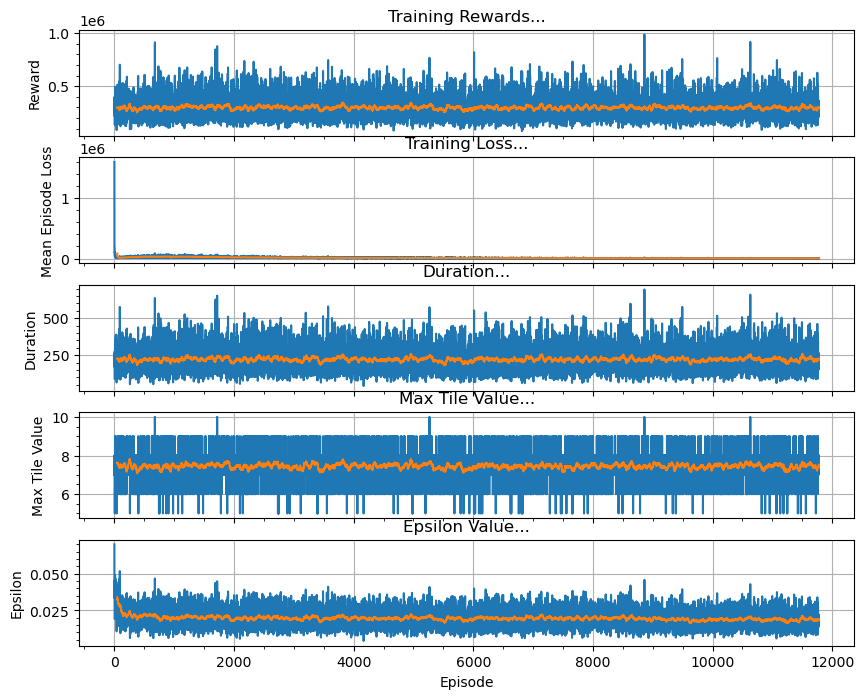

In [15]:
DQN_network(EPISODES_TRAINING)